In [5]:
import requests
import os
import ast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from init import init
user, api_key = init()

In [6]:
def hybrid_event_data(season, event_code, tournament_level, output_dir='data/event'):
    url = f'http://ftc-api.firstinspires.org/v2.0/{season}/schedule/{event_code}/{tournament_level}/hybrid'
    response = requests.get(url, auth=(user, api_key))
    if response.status_code == 200:
        # Parse JSON response
        data = response.json()
        if 'schedule' in data:
            # Convert teams data to DataFrame
            df = pd.DataFrame(data['schedule'])

            output_dir=os.path.join(output_dir, season, event_code)
            # Define the output file path
            os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
            output_file = os.path.join(output_dir, f'event_data_{season}_{event_code}_{tournament_level}.csv')

            # Save DataFrame to CSV
            df.to_csv(output_file, index=False)
            print(f"Event data saved to {output_file}")
            return df, output_file
        else:
            print("No 'teams' key found in the response.")
    else:
        print(f"Failed to fetch data. HTTP status code: {response.status_code}")
        print(f"Response content: {response.text}")

In [7]:
def opr(csv_path, season, event_code, tournament_level, output_dir='data/event'):
    data = pd.read_csv(csv_path)

    # Extract relevant columns
    data['teams'] = data['teams'].apply(ast.literal_eval)  # Convert string representation of list to actual list

    # Initialize variables
    teams = set()
    team_names = {}
    matches = []

    # Parse match data
    for _, row in data.iterrows():
        red_teams = [team['teamNumber'] for team in row['teams'] if 'Red' in team['station']]
        blue_teams = [team['teamNumber'] for team in row['teams'] if 'Blue' in team['station']]

        # Store team names
        for team in row['teams']:
            team_names[team['teamNumber']] = team['teamName']

        matches.append((red_teams, row['scoreRedFinal'], row['scoreRedAuto'], row['scoreRedFinal'] - row['scoreBlueFoul']))
        matches.append((blue_teams, row['scoreBlueFinal'], row['scoreBlueAuto'], row['scoreBlueFinal'] - row['scoreRedFoul']))

        teams.update(red_teams)
        teams.update(blue_teams)

    teams = sorted(teams)
    team_indices = {team: idx for idx, team in enumerate(teams)}

    # Create matrices
    num_matches = len(matches)
    num_teams = len(teams)

    # For total OPR
    A = np.zeros((num_matches, num_teams))
    b = np.zeros(num_matches)

    # For autonomous period OPR
    A_auto = np.zeros((num_matches, num_teams))
    b_auto = np.zeros(num_matches)

    # For non-penalty OPR
    A_np = np.zeros((num_matches, num_teams))
    b_np = np.zeros(num_matches)

    for i, (team_list, score, auto_score, non_penalty_score) in enumerate(matches):
        for team in team_list:
            A[i, team_indices[team]] = 1
            A_auto[i, team_indices[team]] = 1
            A_np[i, team_indices[team]] = 1
        b[i] = score
        b_auto[i] = auto_score
        b_np[i] = non_penalty_score

    # Calculate OPR
    A_transpose = A.T
    A_transpose_A = A_transpose @ A
    A_transpose_b = A_transpose @ b
    opr = np.linalg.solve(A_transpose_A, A_transpose_b)

    # Calculate autonomous period OPR
    A_auto_transpose = A_auto.T
    A_auto_transpose_A = A_auto_transpose @ A_auto
    A_auto_transpose_b = A_auto_transpose @ b_auto
    opr_auto = np.linalg.solve(A_auto_transpose_A, A_auto_transpose_b)

    # Calculate non-penalty OPR
    A_np_transpose = A_np.T
    A_np_transpose_A = A_np_transpose @ A_np
    A_np_transpose_b = A_np_transpose @ b_np
    opr_np = np.linalg.solve(A_np_transpose_A, A_np_transpose_b)

    # Create a DataFrame for results
    opr_df = pd.DataFrame({
        'Team': teams,
        'Team Name': [team_names[team] for team in teams],
        'Total OPR': opr,
        'Autonomous OPR': opr_auto,
        'Non-Penalty OPR': opr_np
    })

    # Sort by Total OPR
    opr_df = opr_df.sort_values(by='Total OPR', ascending=False)

    output_dir = os.path.join(output_dir, season, event_code)
    output_file = os.path.join(output_dir, f'event_opr_{season}_{event_code}_{tournament_level}.csv')
    opr_df.to_csv(output_file, index=False)
    print(f"OPR data saved to {output_file}")
    return opr_df

Event data saved to data/event/2024/USNJNOM5/event_data_2024_USNJNOM5_qual.csv
OPR data saved to data/event/2024/USNJNOM5/event_opr_2024_USNJNOM5_qual.csv
OPR plot saved to data/event/2024/USNJNOM5/event_opr_2024_USNJNOM5_qual.png


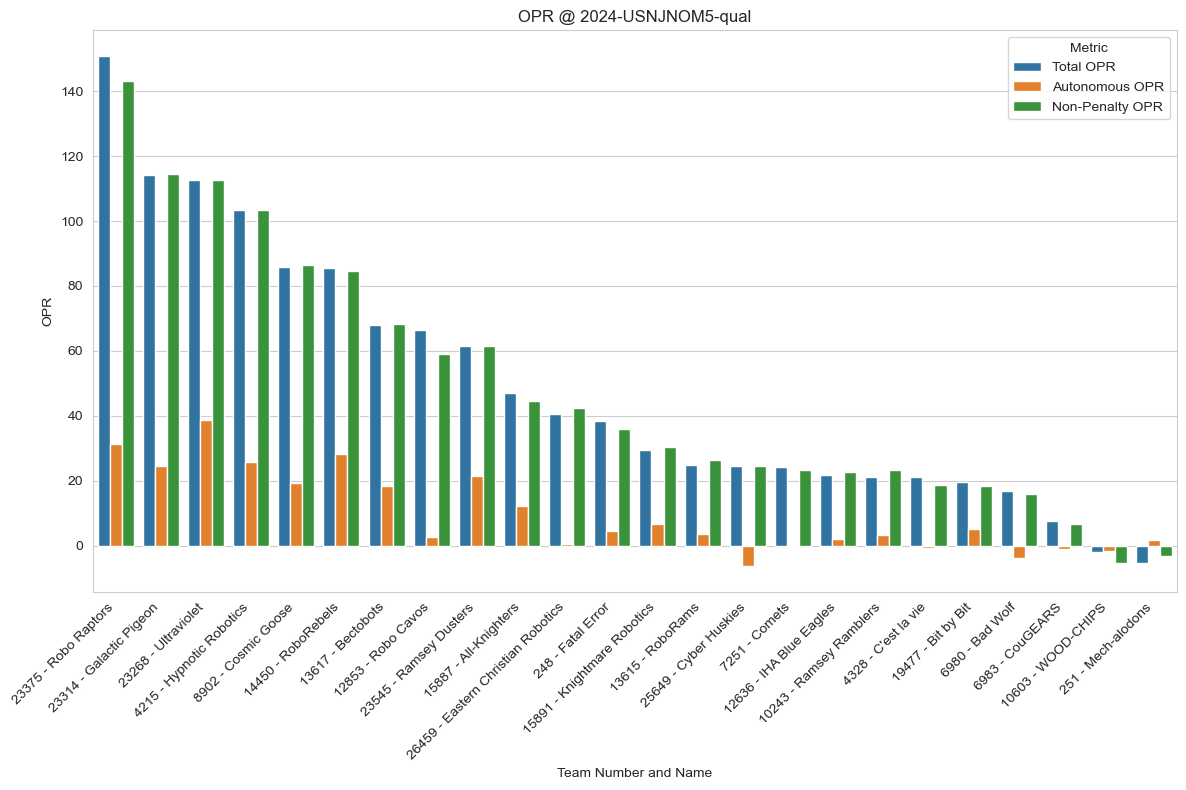

In [10]:
season = '2024'
event_code = 'USNJNOM5'
tournament_level = 'qual'

event_df, path = hybrid_event_data(season, event_code, tournament_level)
opr_df = opr(path, season, event_code, tournament_level)

plt.figure(figsize=(12, 8))
opr_long = opr_df.melt(id_vars=['Team', 'Team Name'], value_vars=['Total OPR', 'Autonomous OPR', 'Non-Penalty OPR'],
                       var_name='Metric', value_name='OPR')
opr_long['Team Display'] = opr_long['Team'].astype(str) + ' - ' + opr_long['Team Name']
sns.barplot(data=opr_long, x='Team Display', y='OPR', hue='Metric')
plt.title(f'OPR @ {season}-{event_code}-{tournament_level}')
plt.xlabel('Team Number and Name')
plt.ylabel('OPR')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()

output_dir = os.path.join("data/event", season, event_code)
plt.savefig(os.path.join(output_dir, f'event_opr_{season}_{event_code}_{tournament_level}.png'))
print("OPR plot saved to", os.path.join(output_dir, f'event_opr_{season}_{event_code}_{tournament_level}.png'))
plt.show()